# Training a weather prediction model with a few more variables

* Other data as inputs (pressure, wind speed etc)
* Encode time as input (e.g. hour of day)
* Wind speed and direction as vector (snazzy!)

In [32]:
import pandas as pd
import numpy as np
from pathlib import Path
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
from sklearn.model_selection import train_test_split
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt

cursor = connect(s3_staging_dir="s3://dantelore.queryresults/pyathena/",
                 region_name="eu-west-1", cursor_class=PandasCursor).cursor()

length = 48
csv_data_cache_filename = "data/weather_models/raw_data_2.csv"
validation_site_name = 'WITTERING'

# Load the data from disk or Athena
if Path(csv_data_cache_filename).is_file():
    print("Loading weather data from cache")
    df = pd.read_csv(csv_data_cache_filename)
else:
    df = cursor.execute(f"select site_name, observation_ts, temperature, pressure, wind_speed, wind_direction from lake.weather order by site_name, observation_ts").as_pandas()
    df.to_csv(csv_data_cache_filename, index=False)

# Drop nulls
df = df.dropna()

# Normalise numeric fields
temperature_offset = df['temperature'].mean()
temperature_scale = df['temperature'].std()
print(f"Offset (mean temp): {temperature_offset}, Scale (stdev temp): {temperature_scale}")
df['temperature'] = df['temperature'].apply(lambda x: (x - temperature_offset) / temperature_scale)     

pressure_offset = df['pressure'].mean()
pressure_scale = df['pressure'].std()
print(f"Offset (mean pressure): {pressure_offset}, Scale (stdev pressure): {pressure_scale}")
df['pressure'] = df['pressure'].apply(lambda x: (x - pressure_offset) / pressure_scale)     

df



Loading weather data from cache
Offset (mean temp): 10.273621344002738, Scale (stdev temp): 5.573310157238021
Offset (mean pressure): 1013.9175258343165, Scale (stdev pressure): 12.165914294106491


,site_name,observation_ts,temperature,pressure,wind_speed,wind_direction
0,ABERDARON,2021-12-12 21:00:00,0.076504,-0.075418,37.0,S
1,ABERDARON,2021-12-12 22:00:00,0.112389,-0.075418,34.0,SSW
2,ABERDARON,2021-12-12 23:00:00,0.148274,0.006779,32.0,SW
3,ABERDARON,2021-12-13 00:00:00,-0.031152,0.088976,28.0,WSW
4,ABERDARON,2021-12-13 01:00:00,-0.049095,0.171173,25.0,WSW
...,...,...,...,...,...,...
1293908,YEOVILTON,2023-01-25 19:00:00,-1.125654,1.239732,1.0,W
1293909,YEOVILTON,2023-01-25 20:00:00,-1.125654,1.239732,3.0,N
1293910,YEOVILTON,2023-01-25 21:00:00,-0.964171,1.239732,6.0,NW
1293911,YEOVILTON,2023-01-25 22:00:00,-0.874457,1.321929,11.0,N


# Feature Engineering

## Encoding the time and date

Time of day is a bit of a sawtooth function, with 23:00 and 00:00 appearing to be much further appart than they are.  Use a cosine to fix this.  Actually, -cos, see below for details.

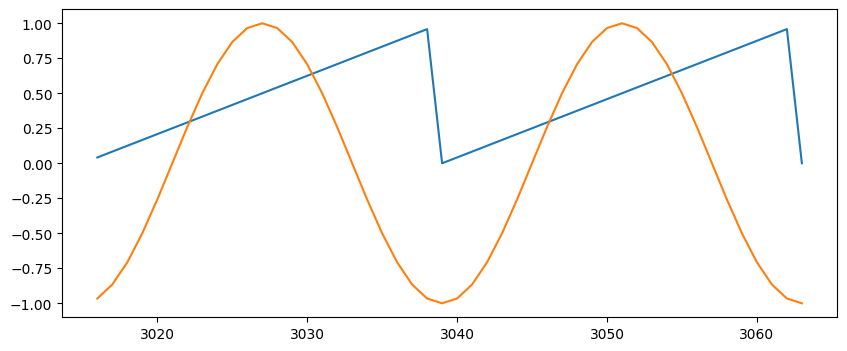

In [33]:
df['observation_ts'] = pd.to_datetime(df['observation_ts'], infer_datetime_format=True)
df['hour'] = df['observation_ts'].dt.hour
df['day_of_year'] = df['observation_ts'].dt.day_of_year

df['hour_cos'] = df['hour'].apply(lambda x: -np.cos(x / 24 * 2 * np.pi))

df['day_of_year_cos'] = df['day_of_year'].apply(lambda x: -np.cos(x / 365 * 2 * np.pi))

df_chart = df[3000:3048]
plt.figure(figsize=(10, 4))
plt.plot(df_chart['hour'].apply(lambda x: x / 24))
plt.plot(df_chart['hour_cos'])
plt.show()

Knowing a bit about how temperature goes up and down through a year and a day, it makes sense to use -cosine for hour_of_day, as the peaks align better.  Same for day of the year (year starts cold, gets warm, then cold again).

It's not a perfect correlation by any means.  The air temp will rise and fall at different times of day, depending on season and all sorts of other factors. But it is close, and it will certainly help the model.

You can see the correlation of the different functions in the corelation matrix, with the highest magnitude correlation with temp being -0.22.  It's not perfect by any means.  But like I say, it is close, and it will certainly help the model.

<AxesSubplot: >

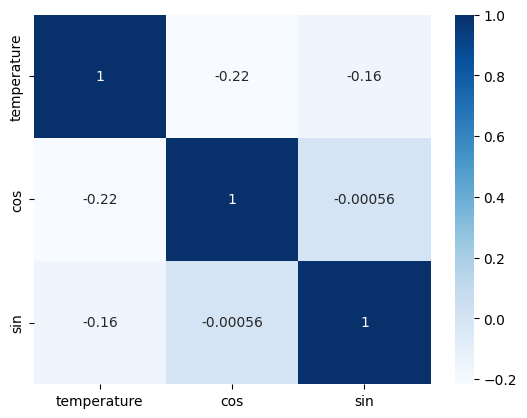

In [34]:
import seaborn as sb

df_chart = df[['hour', 'temperature']].copy()

df_chart['cos'] = df_chart['hour'].apply(lambda x: np.cos(x / 24 * 2 * np.pi))
df_chart['sin'] = df_chart['hour'].apply(lambda x: np.sin(x / 24 * 2 * np.pi))

correlation = df_chart[['temperature', 'cos', 'sin']].corr()
sb.heatmap(correlation, cmap="Blues", annot=True)

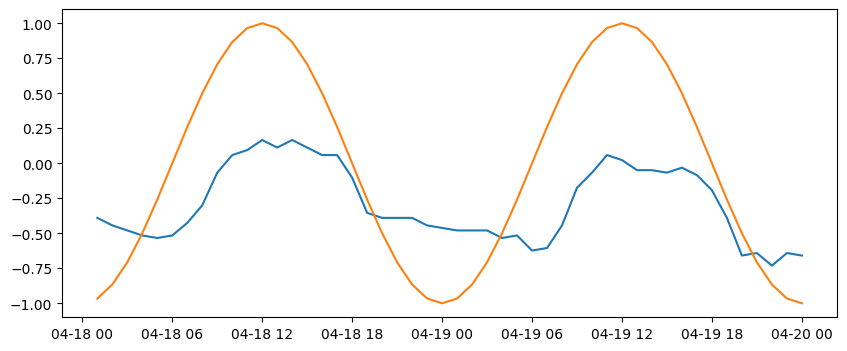

In [35]:
df_chart = df[3000:3048]
plt.figure(figsize=(10, 4))
plt.plot(df_chart['observation_ts'], df_chart['temperature'])
plt.plot(df_chart['observation_ts'], df_chart['hour_cos'])
plt.show()

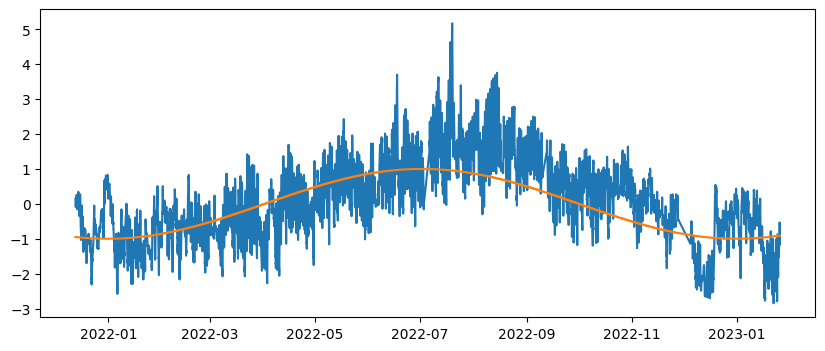

In [36]:
df_chart = df[df['site_name'].eq(validation_site_name)]
plt.figure(figsize=(10, 4))
plt.plot(df_chart['observation_ts'], df_chart['temperature'])
plt.plot(df_chart['observation_ts'], df_chart['day_of_year_cos'])
plt.show()

If you were wondering how well these two time variables work as a predictor for temperature... the answer is... kinda good, kinda bad...

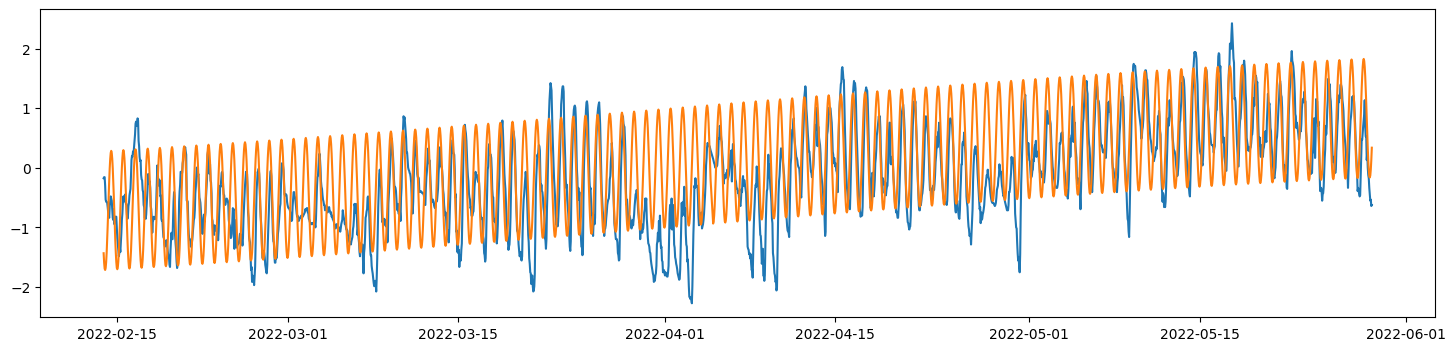

In [37]:
df_chart = df[df['site_name'].eq(validation_site_name)][1500:4000]
plt.figure(figsize=(18, 4))
plt.plot(df_chart['observation_ts'], df_chart['temperature'])
plt.plot(df_chart['observation_ts'], df_chart['day_of_year_cos'] + df_chart['hour_cos'])
plt.show()

## Wind speed and direction

Let's go from a string and a value to a vector in 2D space.

Offset (mean wind_vector_x): -11.624091264840708, Scale (stdev): 33.40088489731596
Offset (mean wind_vector_y): -11.73239279392728, Scale (stdev): 35.70263293420463


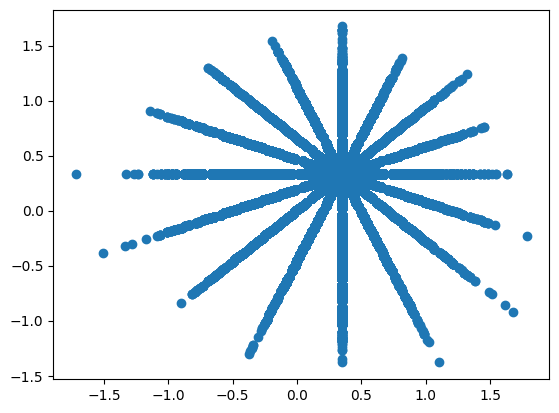

In [38]:
# First convert the nasty text to a compass point

wind_lookup = {
    "N": 0.0,
    "NNE": 22.5,
    "NE": 45.0,
    "ENE": 67.5,
    "E": 90.0,
    "ESE": 112.5,
    "SE": 135.0,
    "SSE": 157.5,
    "S": 180.0,
    "SSW": 202.5,
    "SW": 225.0,
    "WSW": 247.5,
    "W": 270.0,
    "WNW": 292.5,
    "NW": 315.0,
    "NNW": 337.5,
    "": 0.0,
    None: 0.0
}

df['wind_direction_degrees'] = df['wind_direction'].map(wind_lookup)

# Next convert to an X,Y coordinate, using direction and magnitude (wind speed)
def get_x(angle, magnitude):
    return np.cos(angle * np.pi / 180) * magnitude

def get_y(angle, magnitude):
    return np.sin(angle * np.pi / 180) * magnitude

df['wind_vector_x'] = df[['wind_direction_degrees', 'wind_speed']].apply(lambda v: get_x(*v), axis=1)
df['wind_vector_y'] = df[['wind_direction_degrees', 'wind_speed']].apply(lambda v: get_y(*v), axis=1)

# Let's normalise those wind variables. -60 -> +50 is too big a range!
# Also, since wind is not a critical variable, let's make it even smaller
wind_weight = 4
wind_vector_x_offset = df['wind_vector_x'].mean() * wind_weight
wind_vector_x_scale = df['wind_vector_x'].std() * wind_weight
print(f"Offset (mean wind_vector_x): {wind_vector_x_offset}, Scale (stdev): {wind_vector_x_scale}")
df['wind_vector_x'] = df['wind_vector_x'].apply(lambda a: (a - wind_vector_x_offset) / wind_vector_x_scale)   

wind_vector_y_offset = df['wind_vector_y'].mean() * wind_weight
wind_vector_y_scale = df['wind_vector_y'].std() * wind_weight
print(f"Offset (mean wind_vector_y): {wind_vector_y_offset}, Scale (stdev): {wind_vector_y_scale}")
df['wind_vector_y'] = df['wind_vector_y'].apply(lambda a: (a - wind_vector_y_offset) / wind_vector_y_scale)   

# And plot the results...
plt.scatter(df['wind_vector_x'], df['wind_vector_y'])

# Prepare data for training

In [39]:
df = df[['site_name', 'observation_ts', 'temperature', 'pressure', 'wind_vector_x', 'wind_vector_y', 'hour_cos', 'day_of_year_cos']]

# Convert all the numbers to float32 for tensorflow
cols = ['temperature', 'pressure', 'wind_vector_x', 'wind_vector_y', 'hour_cos', 'day_of_year_cos']
df[cols] = df[cols].astype('float32')

df.describe()

/var/folders/rb/9hrlfvs957q0mjt461wvmvzw0000gn/T/ipykernel_10014/929909330.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cols] = df[cols].astype('float32')


,temperature,pressure,wind_vector_x,wind_vector_y,hour_cos,day_of_year_cos
count,1.180697e+06,1.180697e+06,1.180697e+06,1.180697e+06,1.180697e+06,1.180697e+06
mean,1.757602e-09,1.137272e-09,2.610132e-01,2.464607e-01,-6.459089e-04,-8.308528e-02
std,1.000000e+00,1.000000e+00,2.500000e-01,2.500000e-01,7.072634e-01,7.321599e-01
min,-3.565856e+00,-4.103064e+00,-1.717796e+00,-1.379943e+00,-1.000000e+00,-1.000000e+00
25%,-6.770880e-01,-6.507958e-01,1.151442e-01,1.045411e-01,-7.071068e-01,-8.520775e-01
50%,-1.320963e-02,8.897598e-02,2.926968e-01,2.725959e-01,-6.123234e-17,-1.415403e-01
75%,6.506687e-01,6.643540e-01,4.053039e-01,3.880306e-01,7.071068e-01,6.584016e-01
max,5.369588e+00,2.554882e+00,1.786355e+00,1.673053e+00,1.000000e+00,9.999630e-01


In [40]:
# This chunk of code is just here to explain the sliding window function, and use of reshape etc.

i, j = np.ogrid[:10, :4]
x = 10*i + j
print(x.shape)
print(x)

v = sliding_window_view(x, (3,4), axis=(0,1))
v = v.reshape((v.shape[0], v.shape[2], v.shape[3]))
print(v.shape)
print(v)

(10, 4)
[[ 0  1  2  3]
 [10 11 12 13]
 [20 21 22 23]
 [30 31 32 33]
 [40 41 42 43]
 [50 51 52 53]
 [60 61 62 63]
 [70 71 72 73]
 [80 81 82 83]
 [90 91 92 93]]
(8, 3, 4)
[[[ 0  1  2  3]
  [10 11 12 13]
  [20 21 22 23]]

 [[10 11 12 13]
  [20 21 22 23]
  [30 31 32 33]]

 [[20 21 22 23]
  [30 31 32 33]
  [40 41 42 43]]

 [[30 31 32 33]
  [40 41 42 43]
  [50 51 52 53]]

 [[40 41 42 43]
  [50 51 52 53]
  [60 61 62 63]]

 [[50 51 52 53]
  [60 61 62 63]
  [70 71 72 73]]

 [[60 61 62 63]
  [70 71 72 73]
  [80 81 82 83]]

 [[70 71 72 73]
  [80 81 82 83]
  [90 91 92 93]]]


In [41]:
fields = ['temperature', 'pressure', 'wind_vector_x', 'wind_vector_y', 'hour_cos', 'day_of_year_cos']
field_count = len(fields)

input_sequences = np.empty([0, length, 6])
# Window the data
for site_name, readings in df.groupby('site_name'):
    if site_name != validation_site_name:
        values = readings[fields].to_numpy()

        # If ever a bit of code needed a unit tests, this is it.
        v = sliding_window_view(values, window_shape=(length, field_count), axis=(0, 1))
        windows = v.reshape((v.shape[0], v.shape[2], v.shape[3]))

        input_sequences = np.append(windows, input_sequences, axis=0)

        print(f"Window shape site {site_name}: {windows.shape}")

print(f"Combined data shape: {input_sequences.shape}")

# Some funky numpy slicing here.  We are slicing by axis in a 3D array - so xs takes all but the last item on the 2nd axis, ys takes only the last
xs = input_sequences[:,:-1]
ys = input_sequences[:,-1]

# There is no point trying to predict the time at the next timestep!  Drop time fields from the target
ys = np.delete(ys, [-2, -1], axis=1)

x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=1.0/24)

# ((?, 23, 6), (?, 6), (?, 23, 6), (?, 6))
print(f"x_train: {x_train.shape} y_train: {y_train.shape} x_test: {x_test.shape} y_test: {y_test.shape}")

Window shape site ABERDARON: (8799, 48, 6)
Window shape site ABERDEEN AIRPORT: (8718, 48, 6)
Window shape site ABERPORTH: (9469, 48, 6)
Window shape site ABOYNE: (9460, 48, 6)
Window shape site ALBEMARLE: (9482, 48, 6)
Window shape site ALTNAHARRA SAWS: (9432, 48, 6)
Window shape site ANDREWSFIELD: (9398, 48, 6)
Window shape site AULTBEA: (9519, 48, 6)
Window shape site AVIEMORE: (9367, 48, 6)
Window shape site BALLYPATRICK FOREST: (9526, 48, 6)
Window shape site BALTASOUND: (9442, 48, 6)
Window shape site BEDFORD: (9526, 48, 6)
Window shape site BELFAST INTERNATIONAL AIRPORT: (9544, 48, 6)
Window shape site BELMULLET: (9557, 48, 6)
Window shape site BENSON: (9315, 48, 6)
Window shape site BINGLEY SAMOS: (9523, 48, 6)
Window shape site BOSCOMBE DOWN: (9499, 48, 6)
Window shape site BOULMER: (8986, 48, 6)
Window shape site BOURNEMOUTH AIRPORT: (9260, 48, 6)
Window shape site BRIDLINGTON MRSC: (9516, 48, 6)
Window shape site BRIZE NORTON: (9534, 48, 6)
Window shape site CAMBORNE: (9565, 

KeyboardInterrupt: 

# Model Definition

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, InputLayer
from tensorflow.keras.optimizers import Adam

model = Sequential([
    InputLayer((length - 1, 6)), # Input shape here - time steps, features.  We have length-1 steps here, each with 6 features
    LSTM(length * 6, return_sequences=True),
    LSTM(length * 6),
    Dense(units=length * 2, activation='sigmoid'),
    Dense(units=4, activation='linear')
])

adam = Adam(lr=0.01)

model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=adam, metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Create the training history dataframe at the same time as the model...
history_df = pd.DataFrame(columns=['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-01-27 22:44:20.046847: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-27 22:44:20.046970: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 47, 192)           152832    
                                                                 
 lstm_1 (LSTM)               (None, 96)                110976    
                                                                 
 dense (Dense)               (None, 48)                4656      
                                                                 
 dense_1 (Dense)             (None, 4)                 196       
                                                                 
Total params: 268,660
Trainable params: 268,660
Non-trainable params: 0
_________________________________________________________________


/Users/dan/Development/simple-prediction/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Training

Epoch 1/100


111/111 - 215s - loss: 0.0072 - mean_absolute_error: 0.0588 - val_loss: 0.0077 - val_mean_absolute_error: 0.0598 - 215s/epoch - 2s/step
Epoch 2/100


111/111 - 213s - loss: 0.0072 - mean_absolute_error: 0.0586 - val_loss: 0.0076 - val_mean_absolute_error: 0.0596 - 213s/epoch - 2s/step
Epoch 3/100


111/111 - 215s - loss: 0.0071 - mean_absolute_error: 0.0582 - val_loss: 0.0075 - val_mean_absolute_error: 0.0592 - 215s/epoch - 2s/step
Epoch 4/100
111/111 - 207s - loss: 0.0071 - mean_absolute_error: 0.0582 - val_loss: 0.0078 - val_mean_absolute_error: 0.0605 - 207s/epoch - 2s/step
Epoch 5/100
111/111 - 203s - loss: 0.0071 - mean_absolute_error: 0.0582 - val_loss: 0.0076 - val_mean_absolute_error: 0.0598 - 203s/epoch - 2s/step
Epoch 6/100
111/111 - 204s - loss: 0.0071 - mean_absolute_error: 0.0581 - val_loss: 0.0076 - val_mean_absolute_error: 0.0597 - 204s/epoch - 2s/step
Epoch 7/100
111/111 - 204s - loss: 0.0071 - mean_absolute_error: 0.0583 - val_loss: 0.0077 - val_mean_absolute_error: 0.0603 - 204s/epoch - 2s/step
Epoch 8/100
111/111 - 204s - loss: 0.0070 - mean_absolute_error: 0.0580 - val_loss: 0.0076 - val_mean_absolute_error: 0.0596 - 204s/epoch - 2s/step
Epoch 9/100
111/111 - 204s - loss: 0.0070 - mean_absolute_error: 0.0580 - val_loss: 0.0076 - val_mean_absolute_error: 0.0599

111/111 - 211s - loss: 0.0069 - mean_absolute_error: 0.0578 - val_loss: 0.0075 - val_mean_absolute_error: 0.0591 - 211s/epoch - 2s/step
Epoch 14/100
111/111 - 206s - loss: 0.0069 - mean_absolute_error: 0.0578 - val_loss: 0.0077 - val_mean_absolute_error: 0.0596 - 206s/epoch - 2s/step
Epoch 15/100
111/111 - 203s - loss: 0.0069 - mean_absolute_error: 0.0577 - val_loss: 0.0076 - val_mean_absolute_error: 0.0599 - 203s/epoch - 2s/step
Epoch 16/100
111/111 - 203s - loss: 0.0069 - mean_absolute_error: 0.0574 - val_loss: 0.0075 - val_mean_absolute_error: 0.0594 - 203s/epoch - 2s/step
Epoch 17/100
111/111 - 203s - loss: 0.0069 - mean_absolute_error: 0.0576 - val_loss: 0.0075 - val_mean_absolute_error: 0.0594 - 203s/epoch - 2s/step
Epoch 18/100


111/111 - 210s - loss: 0.0069 - mean_absolute_error: 0.0577 - val_loss: 0.0075 - val_mean_absolute_error: 0.0591 - 210s/epoch - 2s/step
Epoch 19/100
111/111 - 206s - loss: 0.0068 - mean_absolute_error: 0.0575 - val_loss: 0.0076 - val_mean_absolute_error: 0.0595 - 206s/epoch - 2s/step
Epoch 20/100
111/111 - 203s - loss: 0.0068 - mean_absolute_error: 0.0576 - val_loss: 0.0076 - val_mean_absolute_error: 0.0595 - 203s/epoch - 2s/step
Epoch 21/100
111/111 - 203s - loss: 0.0068 - mean_absolute_error: 0.0574 - val_loss: 0.0076 - val_mean_absolute_error: 0.0597 - 203s/epoch - 2s/step
Epoch 22/100
111/111 - 203s - loss: 0.0068 - mean_absolute_error: 0.0573 - val_loss: 0.0075 - val_mean_absolute_error: 0.0594 - 203s/epoch - 2s/step
Epoch 23/100
111/111 - 204s - loss: 0.0068 - mean_absolute_error: 0.0573 - val_loss: 0.0076 - val_mean_absolute_error: 0.0596 - 204s/epoch - 2s/step
Epoch 24/100
111/111 - 203s - loss: 0.0068 - mean_absolute_error: 0.0574 - val_loss: 0.0077 - val_mean_absolute_error: 

111/111 - 210s - loss: 0.0067 - mean_absolute_error: 0.0571 - val_loss: 0.0075 - val_mean_absolute_error: 0.0593 - 210s/epoch - 2s/step
Epoch 28/100
111/111 - 206s - loss: 0.0068 - mean_absolute_error: 0.0573 - val_loss: 0.0075 - val_mean_absolute_error: 0.0592 - 206s/epoch - 2s/step
Epoch 29/100
111/111 - 203s - loss: 0.0067 - mean_absolute_error: 0.0570 - val_loss: 0.0076 - val_mean_absolute_error: 0.0593 - 203s/epoch - 2s/step
Epoch 30/100
111/111 - 204s - loss: 0.0067 - mean_absolute_error: 0.0571 - val_loss: 0.0075 - val_mean_absolute_error: 0.0593 - 204s/epoch - 2s/step
Epoch 31/100
111/111 - 203s - loss: 0.0067 - mean_absolute_error: 0.0571 - val_loss: 0.0076 - val_mean_absolute_error: 0.0598 - 203s/epoch - 2s/step
Epoch 32/100
111/111 - 204s - loss: 0.0067 - mean_absolute_error: 0.0569 - val_loss: 0.0078 - val_mean_absolute_error: 0.0611 - 204s/epoch - 2s/step
Epoch 33/100
111/111 - 204s - loss: 0.0067 - mean_absolute_error: 0.0570 - val_loss: 0.0076 - val_mean_absolute_error: 

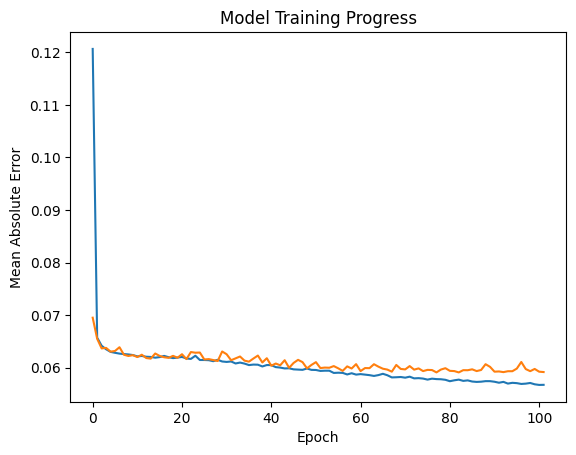

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

tf.get_logger().setLevel('ERROR')

model_filename = 'data/weather_models/model2/'

cp = ModelCheckpoint(model_filename, save_best_only=True, verbose=0)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Use verbose=2 here to prevent progreess bars locking up jupyter after a few hours
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, verbose=2, callbacks=[cp, es], batch_size=10000)

history_df = pd.concat([history_df, pd.DataFrame(history.history)], ignore_index=True)

plt.plot(history_df['mean_absolute_error'], label="Training Error")
plt.plot(history_df['val_mean_absolute_error'], label="Validation Error")
plt.title(f'Model Training Progress')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.show()

# Results/Performance

6/6 [==============================] - 0s 18ms/step


,predicted_temperature,predicted_pressure,predicted_wind_vector_x,predicted_wind_vector_y,actual_temperature,actual_pressure,actual_wind_vector_x,actual_wind_vector_y,actual_hour_cos,actual_day_of_year_cos
0,-0.376479,1.244725,0.549839,0.315564,-0.730916,0.910945,0.348017,0.076532,-8.660254e-01,-0.158559
1,-1.055057,1.025069,0.509972,0.244656,-0.695031,0.993141,0.348017,0.048523,-9.659258e-01,-0.158559
2,-0.619986,1.101025,0.468894,0.293506,-0.820629,0.993141,0.348017,0.048523,-1.000000e+00,-0.175531
3,-0.802238,1.047588,0.410163,0.319114,-0.892400,0.993141,0.348017,0.104541,-9.659258e-01,-0.175531
4,-1.085920,0.775083,0.404159,0.166334,-0.910343,0.993141,0.348017,0.104541,-8.660254e-01,-0.175531
...,...,...,...,...,...,...,...,...,...,...
162,1.368143,0.105264,0.185490,0.199010,1.027465,0.417763,0.009293,0.011727,5.000000e-01,-0.276097
163,1.233363,0.444560,0.376809,0.387278,0.848038,0.417763,0.072804,0.071143,2.588190e-01,-0.276097
164,1.221414,0.433200,0.501359,0.425228,0.363586,0.499960,0.154395,0.253584,1.836970e-16,-0.276097
165,0.448018,0.672322,0.142767,0.330076,0.202102,0.582157,0.178655,0.170171,-2.588190e-01,-0.276097


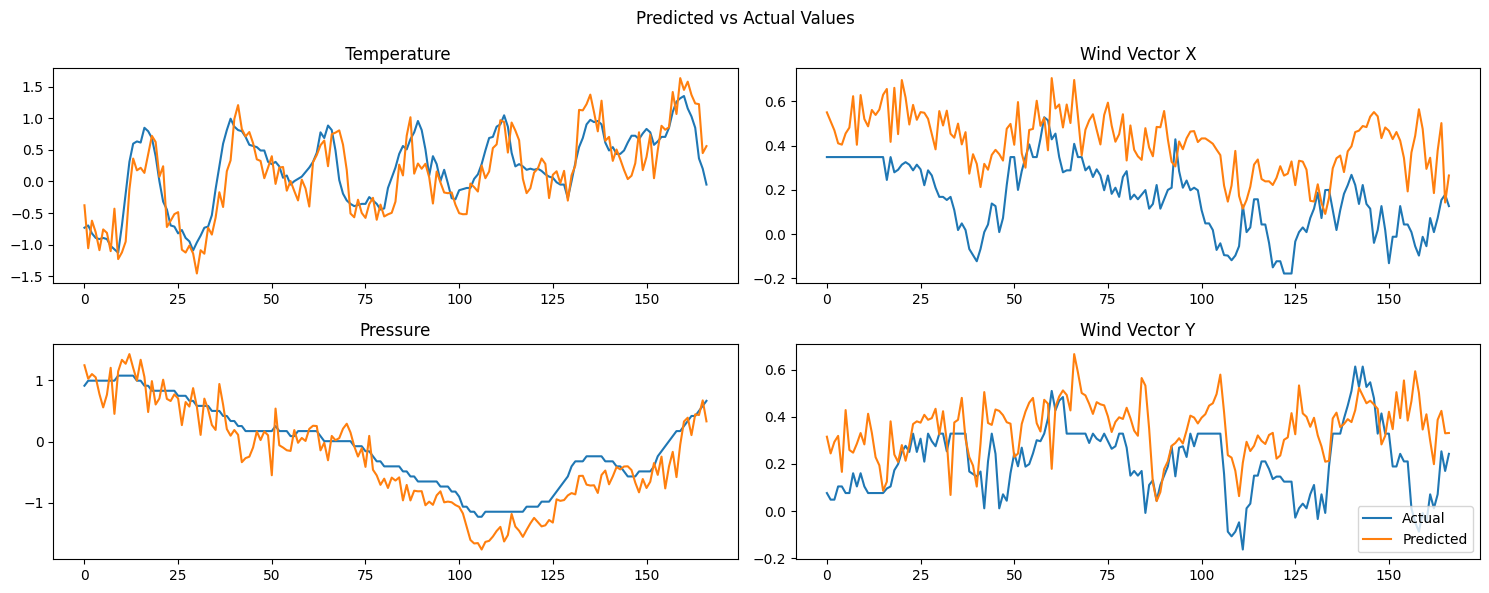

In [ ]:
df_validate = df[df['site_name'].eq(validation_site_name)][fields]

values = df_validate.to_numpy()

v = sliding_window_view(values, window_shape=(length, field_count), axis=(0, 1))
windows = v.reshape((v.shape[0], v.shape[2], v.shape[3]))

l = 24 * 7 # Show 7 days on the chart
from_end = 24 * 90 # days to step back
windows = windows[-l - from_end:-1 - from_end]

model_inputs = windows[:,:-1]
actuals = windows[:,-1]

results = model.predict(model_inputs)
train_predictions = pd.DataFrame(results, columns=[f"predicted_{name}" for name in fields[:-2]])
train_actuals = pd.DataFrame(actuals, columns=[f"actual_{name}" for name in fields])

train_results = train_predictions.join(train_actuals)

#train_results['Predicted'] = train_results['Predicted'].apply(lambda x: x * scale + offset)
#train_results['Actual'] = train_results['Actual'].apply(lambda x: x * scale + offset)

fig, axs = plt.subplots(2, 2, figsize=(15, 6))
fig.suptitle('Predicted vs Actual Values')

axs[0,0].plot(train_results['actual_temperature'])
axs[0,0].plot(train_results['predicted_temperature'])
axs[0,0].set_title(f' Temperature')

axs[1,0].plot(train_results['actual_pressure'])
axs[1,0].plot(train_results['predicted_pressure'])
axs[1,0].set_title(f'Pressure')

axs[0,1].plot(train_results['actual_wind_vector_x'])
axs[0,1].plot(train_results['predicted_wind_vector_x'])
axs[0,1].set_title(f'Wind Vector X')

axs[1,1].plot(train_results['actual_wind_vector_y'], label="Actual")
axs[1,1].plot(train_results['predicted_wind_vector_y'], label="Predicted")
axs[1,1].set_title(f'Wind Vector Y')
axs[1,1].legend(loc="lower right")

fig.tight_layout()

train_results